# 1. Preparing Data

In [27]:
#source: https://jaketae.github.io/study/word2vec/

In [5]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

# 2. Tokenization

In [10]:
#The first step, as is the approach taken in many NLP tasks, is to tokenize the text, i.e. splitting the text up into smaller units like words, getting rid of punctuations, and so on

import re

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())



In [14]:
#The returned object will be a list containing all the tokens in text
tokens = tokenize(text)

In [15]:
#create a map between tokens and indices, and vice versa
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

In [17]:
#Checking
word_to_id, id_to_word = mapping(tokens)
word_to_id

{'sample': 0,
 'as': 1,
 'tasks': 2,
 'perform': 3,
 'seen': 4,
 'experience': 5,
 'known': 6,
 'the': 7,
 'infeasible': 8,
 'to': 9,
 'so': 10,
 'predictions': 11,
 'explicitly': 12,
 'make': 13,
 'a': 14,
 'and': 15,
 'wide': 16,
 'subset': 17,
 'study': 18,
 'email': 19,
 'mathematical': 20,
 'that': 21,
 'data': 22,
 'used': 23,
 'of': 24,
 'artificial': 25,
 'applications': 26,
 'order': 27,
 'variety': 28,
 'automatically': 29,
 'intelligence': 30,
 'or': 31,
 'learning': 32,
 'build': 33,
 'training': 34,
 'such': 35,
 'decisions': 36,
 'computer': 37,
 'develop': 38,
 'being': 39,
 'conventional': 40,
 'on': 41,
 'are': 42,
 'in': 43,
 'needed': 44,
 'vision': 45,
 'is': 46,
 'it': 47,
 'without': 48,
 'programmed': 49,
 'based': 50,
 'where': 51,
 'algorithms': 52,
 'through': 53,
 'filtering': 54,
 'machine': 55,
 'difficult': 56,
 'do': 57,
 'model': 58,
 'improve': 59}

# 3. Generating Training Data

In [19]:
import numpy as np

np.random.seed(42)


def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

In [20]:
#concat, an auxiliary function we used above to combine two range() objects.
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [21]:
# represent each token as a vector, which can then be stacked to create the matrices X and y
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

In [23]:
# generate some training data with a window size of two

X, y = generate_training_data(tokens, word_to_id, 2)

In [26]:
# Check the dimensionality of the data
X.shape, y.shape

"""
Here, 330 is the number of training examples we have.
60 is the size of our corpus, or the number of unique tokens we have in the original text.
"""

((330, 60), (330, 60))

# 4. The Embedding Model

In [28]:
# theory

# 5. Code Implementation

In [29]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [31]:
# create ten-dimensional embeddings
model = init_network(len(word_to_id), 10)

# 6. Forward Propagation

In [33]:
# Coding the forward propagation process simply amounts to transcribing the three matrix multiplication equations

def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache

def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

In [34]:
# check the dimensionality of the matrices
(X @ model["w1"]).shape


(330, 10)

In [35]:
# check the dimensionality after passing through the second layer
(X @ model["w1"] @ model["w2"]).shape

(330, 60)

# 7. Backpropagation

In [36]:
def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

In [37]:
# cross entropy loss function
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

# 8. Testing the Model

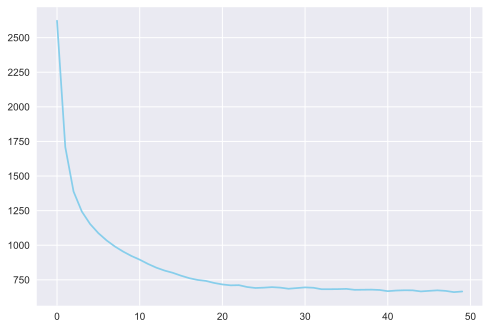

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [39]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
so
intelligence
are
is
build
the
automatically
perform
algorithms
through
tasks
learning
seen
experience
that
to
improve
conventional
study
needed
used
develop
based
subset
decisions
difficult
do
programmed
on
artificial
vision
predictions
explicitly
mathematical
wide
order
infeasible
model
make
known
computer
without
a
training
it
or
where
filtering
applications
email
such
data
variety
being
sample
in
of
and
as


# 8. Embedding

In [40]:
model["w1"]

array([[-1.47807438e+00,  4.67768247e-01, -1.02221434e+00,
         1.10499361e+00, -6.01254923e-01,  8.52629299e-03,
        -1.55395062e+00,  5.26892056e-01, -1.33294894e+00,
         1.29329558e+00],
       [-1.98678332e+00, -5.85275026e-01,  3.61450155e-01,
         1.15069880e+00, -8.89809133e-01, -1.15737942e+00,
        -4.45263496e-01, -1.04777627e+00, -1.45409350e+00,
         9.79104512e-01],
       [-8.64982719e-01,  1.20927560e+00,  1.42317151e+00,
        -4.81375872e-03, -1.12095425e-01,  1.12134439e+00,
         3.32771703e-01,  4.75561448e-01,  1.12178612e+00,
         2.37737723e+00],
       [-6.19667751e-01,  4.31537049e-01,  2.38610344e+00,
         3.12708055e-01, -1.82384600e-01,  1.63363060e+00,
         9.53865446e-01,  5.98124080e-01,  1.00376967e+00,
         1.43864414e+00],
       [-8.06433459e-01,  3.80583371e-01, -3.63689043e-01,
        -9.48681226e-01, -6.94952552e-01, -1.32255144e+00,
         7.89988290e-01, -2.25369937e+00, -1.70744623e+00,
        -9.

In [41]:
# input a word through a function and receive as output the embedding vector for that given word

def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [42]:
# test out the word “machine”
get_embedding(model, "machine")

array([-0.99603879,  0.76402942, -0.8974262 , -1.2205266 ,  0.00239933,
        0.16869316,  1.48124901, -1.47637373,  0.89624084, -0.34208583])